In [1]:
%matplotlib inline

import copy
from datetime import date
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy import integrate
import sys
import time
import torch as pt

sys.path.insert(0, '../..')

from function_space import Constant, Linear, DenseNet, NN, NN_Nik, SingleParam, MySequential
from problems import DoubleWell, DoubleWell_multidim, DoubleWell_OU, LQGC, LLGC, DoubleWell_multidim
from solver import Solver
from utilities import do_importance_sampling, do_importance_sampling_Wei, plot_control_for_DoubleWell1d, plot_loss_logs, plot_solution, save_exp_logs, load_exp_logs

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

In [2]:
d = 5

def integrand(x):
    return np.exp(2 / d * np.cos(x))

np.sqrt(integrate.quad(integrand, 0, 2 * np.pi)[0]**d / (2 * np.pi)**d)

1.1040855314961615

In [3]:
def hat_function(x):
    return pt.exp(-200 * x**2) * ((x > -0.2) & (x < 0.2))

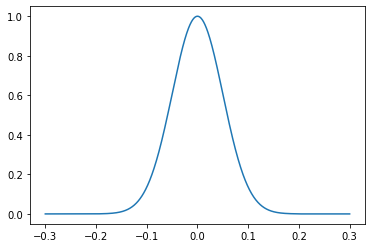

In [4]:
plt.plot(pt.linspace(-0.3, 0.3, 1000), hat_function(pt.linspace(-0.3, 0.3, 1000)));

In [5]:
class DenseNet_2(pt.nn.Module):
    def __init__(self, d_in, d_out, lr, arch=[30, 30], seed=42):
        super(DenseNet_2, self).__init__()
        pt.manual_seed(seed)
        self.nn_dims = [d_in] + arch + [d_out]
        self.layers = pt.nn.ModuleList([pt.nn.Linear(sum(self.nn_dims[:i + 1]), self.nn_dims[i + 1])
                                        for i in range(len(self.nn_dims) - 1)])   
        self.optim = pt.optim.Adam(self.parameters(), lr=lr)
        self.relu = pt.nn.ReLU()

    def forward(self, x):
        for i in range(len(self.nn_dims) - 1):
            if i == len(self.nn_dims) - 2:
                x = self.layers[i](x)
            else:
                x = pt.cat([x, pt.nn.functional.tanh(self.layers[i](x))], dim=1)
        return pt.nn.functional.relu(x) # x # 
    
class SingleParam(pt.nn.Module):
    def __init__(self, lr, initial=None, seed=42):
        super(SingleParam, self).__init__()
        pt.manual_seed(seed)
        if initial is None:
            self.Y_0 = pt.nn.Parameter(pt.tensor([0.0]), requires_grad=True)
        elif initial == 'random':
            self.Y_0 = pt.nn.Parameter(pt.randn(1), requires_grad=True)
        else:
            self.Y_0 = pt.nn.Parameter(pt.tensor([initial]), requires_grad=True)

        self.register_parameter('param', self.Y_0)
        self.optim = pt.optim.Adam(self.parameters(), lr=lr)
        #self.optim = pt.optim.SGD(self.parameters(), lr=lr)

    def forward(self, x):
        return self.Y_0
    
class DenseNet(pt.nn.Module):
    def __init__(self, d_in, d_out, lr, arch=[30, 30], seed=42):
        super(DenseNet, self).__init__()
        pt.manual_seed(seed)
        self.nn_dims = [d_in] + arch + [d_out]
        self.W = [item for sublist in
                  [[pt.nn.Parameter(pt.randn(sum(self.nn_dims[:i + 1]), self.nn_dims[i + 1],
                                             requires_grad=True) * 0.1),
                    pt.nn.Parameter(0.1 * pt.ones(self.nn_dims[i + 1], requires_grad=True))] for
                   i in range(len(self.nn_dims) - 1)]
                  for item in sublist]
        self.relu = pt.nn.ReLU()
        self.sigmoid = pt.nn.Sigmoid()

        for i, w in enumerate(self.W):
            self.register_parameter('param %d' % i, w)

        self.optim = pt.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        for i in range(len(self.nn_dims) - 1):
            if i == len(self.nn_dims) - 2:
                x = pt.matmul(x, self.W[2 * i]) + self.W[2 * i + 1]
            else:
                x = pt.cat([x, pt.nn.functional.relu(pt.matmul(x, self.W[2 * i])
                                                     + self.W[2 * i + 1]) ** 2], dim=1)
        return x

In [6]:
class Eigenvalue():
    def __init__(self, name='Eigenvalue', d=1):
        self.name = name
        self.d = d
        self.c = 1.1040855314961615
        self.B = (pt.sqrt(pt.tensor(2.0)) * pt.eye(self.d)).to(device)
        self.X_0 = pt.tensor(np.pi) * pt.ones(self.d).to(device)
        self.Y_0 = pt.zeros(1).to(device)
        self.lambda_ = -3.0
        self.X_l = 0.0
        self.X_r = 2 * np.pi

    def b(self, x):
        return pt.zeros(x.shape).to(device)

    def sigma(self, x):
        return self.B

    def g(self, x):
        #return pt.exp(self.alpha * pt.sqrt(pt.sum(x**2, 1)))
        return pt.zeros(x.shape[0]).to(device)

    def h(self, x, y, z):
        return -y**3 - y * (-1 / self.c**2 * pt.exp(2 / self.d * pt.sum(pt.cos(x), 1)) 
                            + pt.sum((pt.sin(x)**2 / self.d**2 - pt.cos(x) / self.d), 1) - 3)
   
    #def u_true(self, x):
    #    return -self.B * pt.tensor(np.pi) * pt.cos(pt.tensor(np.pi) * x)
   
    def v_true(self, x):
        #return pt.exp(self.alpha * pt.sqrt(pt.sum(x**2, 1)))
        return 1 / self.c * pt.exp(1 / self.d * pt.sum(pt.cos(x), 1))

In [9]:
d = 5

problem = Eigenvalue(d=d)

V = DenseNet_2(d, 1, lr=0.001, arch=[15, 15, 15, 15]).to(device)
lambda_ = SingleParam(initial=-2.0, lr=0.001).to(device)

In [10]:
alpha = [50.0, 1.0]

L = 200000
N = 20
K = 500
K_boundary = 50
print_every = 100
delta_t = pt.tensor([0.001]).to(device)
delta_t_np = delta_t.cpu().numpy()
sq_delta_t = pt.sqrt(delta_t)

adaptive_forward_process = False
detach_forward = True

loss_log = []
loss_log_boundary = []
loss_log_derivative_boundary = []
loss_log_domain = []
loss_log_center = []
V_L2_log = []
times = []
y_0_log = []
lambda_log = []

for l in range(L):

    t_0 = time.time()

    loss = 0

    #X_center = 0.5 * pt.ones(1, d) # problem.X_0.repeat(1, 1).to(device)
    #loss += pt.mean((V(X_center).squeeze() - problem.v_true(X_center).squeeze())**2)

    X_2 = (problem.X_r - problem.X_l) * pt.rand(K, problem.d).to(device) + problem.X_l
    
    loss += 1.0 * hat_function(pt.mean(V(X_2).squeeze()**2))
    
    loss += 0.01 * (pt.mean(V(X_2).squeeze()**2) - 1)**2
    
    loss_log_center.append(0.01 * ((pt.mean(V(X_2).squeeze()**2) - 1)**2).item())

    # sample uniformly on boundary
    s = np.concatenate([np.ones(int(K_boundary / 2))[:, np.newaxis], np.zeros([int(K_boundary / 2), d - 1])], 1)
    np.apply_along_axis(np.random.shuffle, 1, s)
    a = np.concatenate([s, np.zeros([int(K_boundary / 2), problem.d])]).astype(bool)
    b = np.concatenate([np.zeros([int(K_boundary / 2), problem.d]), s]).astype(bool)
    X_boundary = (problem.X_r - problem.X_l) * pt.rand(K_boundary, problem.d).to(device) + problem.X_l
    X_boundary_reflect = copy.deepcopy(X_boundary)
    X_boundary[pt.tensor(a.astype(float)).bool()] = problem.X_l
    X_boundary_reflect[pt.tensor(a.astype(float)).bool()] = problem.X_r
    X_boundary[pt.tensor(b.astype(float)).bool()] = problem.X_r
    X_boundary_reflect[pt.tensor(b.astype(float)).bool()] = problem.X_l

    loss += alpha[1] * pt.mean((V(X_boundary).squeeze() - V(X_boundary_reflect).squeeze())**2)
    loss_log_boundary.append(pt.mean((V(X_boundary).squeeze() - V(X_boundary_reflect).squeeze())**2).item())
    
    X_boundary = pt.autograd.Variable(X_boundary, requires_grad=True)
    X_boundary_reflect = pt.autograd.Variable(X_boundary_reflect, requires_grad=True)

    Y_reflect = V(X_boundary_reflect)
    Y_eval_reflect = Y_reflect.squeeze().sum()
    Y_eval_reflect.backward(retain_graph=True)
    grad_V_reflect, = pt.autograd.grad(Y_eval_reflect, X_boundary_reflect, create_graph=True)

    Y_ = V(X_boundary)
    Y_eval = Y_.squeeze().sum()
    Y_eval.backward(retain_graph=True)
    grad_V, = pt.autograd.grad(Y_eval, X_boundary, create_graph=True)
    
    loss += alpha[1] * pt.mean((grad_V - grad_V_reflect)**2)
    loss_log_derivative_boundary.append( pt.mean((grad_V - grad_V_reflect)**2).item())

    X = (problem.X_r - problem.X_l) * pt.rand(K, problem.d).to(device) + problem.X_l

    X = pt.autograd.Variable(X, requires_grad=True)
    Y = pt.zeros(K).to(device)

    #lambda_log.append(lambda_(X)[0].item())
    stopped = pt.zeros(K).bool().to(device)
    hitting_times = pt.zeros(K)
    V_L2 = pt.zeros(K)

    phi_0 = V(X).squeeze()

    for n in range(N):

        Y_ = V(X)
        Y_eval = Y_.squeeze().sum()
        Y_eval.backward(retain_graph=True)
        Z, = pt.autograd.grad(Y_eval, X, create_graph=True)
        Z = pt.mm(problem.sigma(X).t(), Z.t()).t()

        xi = pt.randn(K, d).to(device)

        selection = ~stopped
        K_selection = pt.sum(selection)
        if K_selection == 0:
            break

        V_L2[selection] += ((V(X[selection]).squeeze() - pt.tensor(problem.v_true(X[selection])).float().squeeze())**2).detach().cpu() * delta_t.cpu()

        c = pt.zeros(d, K).to(device)
        if adaptive_forward_process is True:
            c = -Z.t()
        if detach_forward is True:
            c = c.detach()

        X_proposal = (X + ((problem.b(X) + pt.mm(problem.sigma(X), c).t()) * delta_t
             + pt.mm(problem.sigma(X), xi.t()).t() * sq_delta_t) * selection.float().unsqueeze(1).repeat(1, d))

        hitting_times[selection] += 1
        new_selection = pt.all((X_proposal >= problem.X_l) & (X_proposal <= problem.X_r), 1).to(device)

        Y = (Y + ((- problem.h(X, Y_.squeeze(), Z) - lambda_(X) * Y_.squeeze() #+ 3 * Y_.squeeze() #  lambda_(X) 
                       + pt.sum(Z * c.t(), 1)) * delta_t + pt.sum(Z * xi, 1) * sq_delta_t) * (new_selection & ~stopped).float())

        X_ = X
        X = (X * (~new_selection | stopped).float().unsqueeze(1).repeat(1, d) 
             + X_proposal * (new_selection & ~stopped).float().unsqueeze(1).repeat(1, d))

        if pt.sum(~new_selection & ~stopped) > 0:
            stopped[~new_selection & ~stopped] += True

    loss += alpha[0] * pt.mean((V(X).squeeze() - phi_0 - Y)**2)
    
    #loss += 0.0001 * lambda_(X)[0]
    
    loss_log_domain.append(pt.mean((V(X).squeeze() - phi_0 - Y)**2).item())
    V.zero_grad()
    lambda_.zero_grad()

    #if loss_with_stopped:
    #    loss += alpha[0] * pt.mean((Y[stopped] - problem.g(X[stopped, :]))**2)
    loss.backward(retain_graph=True)
    V.optim.step()

    lambda_.optim.step()

    loss_log.append(loss.item())
    V_L2_log.append(pt.mean(V_L2).item())
    lambda_log.append(lambda_(X)[0].item())

    #if K_test_log is not None:
    #    V_test_log.append(compute_test_error(self, problem, K_test_log, device))

    t_1 = time.time()
    times.append(t_1 - t_0)

    if l % print_every == 0:
        print('%d - loss = %.4e, v L2 error = %.4e, lambda = %.4e, n = %d, active: %d/%d, %.2f' % 
              (l, loss_log[-1], V_L2_log[-1], lambda_log[-1], n, K_selection, K, np.mean(times[-print_every:])))


/home/lorenz/.local/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 - loss = 3.6337e-01, v L2 error = 5.2840e-03, lambda = -2.0010e+00, n = 19, active: 415/500, 0.51
100 - loss = 1.9884e-02, v L2 error = 5.7811e-03, lambda = -2.0967e+00, n = 19, active: 412/500, 0.48
200 - loss = 1.6799e-02, v L2 error = 5.3200e-03, lambda = -2.1915e+00, n = 19, active: 409/500, 0.50
300 - loss = 1.4528e-02, v L2 error = 5.0906e-03, lambda = -2.2817e+00, n = 19, active: 417/500, 0.46
400 - loss = 1.4917e-02, v L2 error = 5.8118e-03, lambda = -2.3669e+00, n = 19, active: 406/500, 0.48
500 - loss = 1.4126e-02, v L2 error = 6.2620e-03, lambda = -2.4479e+00, n = 19, active: 391/500, 0.45
600 - loss = 1.2071e-02, v L2 error = 5.2886e-03, lambda = -2.5251e+00, n = 19, active: 414/500, 0.45
700 - loss = 1.2656e-02, v L2 error = 6.1030e-03, lambda = -2.5992e+00, n = 19, active: 417/500, 0.45
800 - loss = 1.1440e-02, v L2 error = 5.2019e-03, lambda = -2.6704e+00, n = 19, active: 408/500, 0.50
900 - loss = 1.0958e-02, v L2 error = 5.0712e-03, lambda = -2.7385e+00, n = 19, acti

8000 - loss = 1.8148e-03, v L2 error = 3.5482e-05, lambda = -3.0447e+00, n = 19, active: 386/500, 0.43
8100 - loss = 1.8189e-03, v L2 error = 3.4076e-05, lambda = -3.0437e+00, n = 19, active: 409/500, 0.42
8200 - loss = 1.8728e-03, v L2 error = 3.7528e-05, lambda = -3.0450e+00, n = 19, active: 396/500, 0.44
8300 - loss = 1.6909e-03, v L2 error = 3.5944e-05, lambda = -3.0395e+00, n = 19, active: 396/500, 0.43
8400 - loss = 1.8705e-03, v L2 error = 3.1938e-05, lambda = -3.0398e+00, n = 19, active: 399/500, 0.44
8500 - loss = 2.1101e-03, v L2 error = 4.3113e-05, lambda = -3.0383e+00, n = 19, active: 400/500, 0.43
8600 - loss = 1.4366e-03, v L2 error = 2.9091e-05, lambda = -3.0369e+00, n = 19, active: 406/500, 0.44
8700 - loss = 2.0574e-03, v L2 error = 3.0020e-05, lambda = -3.0365e+00, n = 19, active: 400/500, 0.43
8800 - loss = 1.8539e-03, v L2 error = 2.9257e-05, lambda = -3.0369e+00, n = 19, active: 407/500, 0.43
8900 - loss = 1.7034e-03, v L2 error = 2.3454e-05, lambda = -3.0334e+00, 

15900 - loss = 5.9509e-04, v L2 error = 3.5283e-06, lambda = -3.0105e+00, n = 19, active: 402/500, 0.42
16000 - loss = 4.6050e-04, v L2 error = 4.1069e-06, lambda = -3.0075e+00, n = 19, active: 401/500, 0.43
16100 - loss = 6.5828e-04, v L2 error = 8.0530e-06, lambda = -3.0093e+00, n = 19, active: 404/500, 0.44
16200 - loss = 5.4341e-04, v L2 error = 4.6984e-06, lambda = -3.0094e+00, n = 19, active: 399/500, 0.43
16300 - loss = 5.3369e-04, v L2 error = 4.6047e-06, lambda = -3.0097e+00, n = 19, active: 412/500, 0.43
16400 - loss = 6.1074e-04, v L2 error = 5.6413e-06, lambda = -3.0106e+00, n = 19, active: 381/500, 0.43
16500 - loss = 4.8430e-04, v L2 error = 3.5927e-06, lambda = -3.0119e+00, n = 19, active: 398/500, 0.42
16600 - loss = 5.0357e-04, v L2 error = 3.3278e-06, lambda = -3.0088e+00, n = 19, active: 415/500, 0.43
16700 - loss = 4.9952e-04, v L2 error = 8.7690e-06, lambda = -3.0075e+00, n = 19, active: 393/500, 0.43
16800 - loss = 4.6787e-04, v L2 error = 3.3709e-06, lambda = -3.

24000 - loss = 5.6516e-04, v L2 error = 1.1171e-05, lambda = -3.0102e+00, n = 19, active: 409/500, 0.43
24100 - loss = 2.8906e-04, v L2 error = 1.1367e-06, lambda = -3.0070e+00, n = 19, active: 410/500, 0.44
24200 - loss = 3.8756e-04, v L2 error = 1.7026e-06, lambda = -3.0101e+00, n = 19, active: 420/500, 0.44
24300 - loss = 4.8995e-04, v L2 error = 4.2693e-06, lambda = -3.0073e+00, n = 19, active: 421/500, 0.43
24400 - loss = 3.9755e-04, v L2 error = 3.0681e-06, lambda = -3.0033e+00, n = 19, active: 400/500, 0.43
24500 - loss = 3.3715e-04, v L2 error = 2.1889e-06, lambda = -3.0090e+00, n = 19, active: 400/500, 0.43
24600 - loss = 3.8222e-04, v L2 error = 2.5245e-06, lambda = -3.0063e+00, n = 19, active: 398/500, 0.43
24700 - loss = 3.6944e-04, v L2 error = 2.6863e-06, lambda = -3.0055e+00, n = 19, active: 414/500, 0.43
24800 - loss = 3.1959e-04, v L2 error = 1.5772e-06, lambda = -3.0128e+00, n = 19, active: 400/500, 0.44
24900 - loss = 4.3789e-04, v L2 error = 3.3049e-06, lambda = -3.

31900 - loss = 2.8749e-04, v L2 error = 2.6469e-06, lambda = -3.0026e+00, n = 19, active: 391/500, 0.42
32000 - loss = 4.1692e-04, v L2 error = 8.4334e-06, lambda = -3.0069e+00, n = 19, active: 409/500, 0.43
32100 - loss = 4.0135e-04, v L2 error = 1.5273e-06, lambda = -3.0064e+00, n = 19, active: 405/500, 0.42
32200 - loss = 3.7810e-04, v L2 error = 2.7631e-06, lambda = -3.0057e+00, n = 19, active: 397/500, 0.43
32300 - loss = 4.3424e-04, v L2 error = 4.6640e-06, lambda = -3.0096e+00, n = 19, active: 391/500, 0.43
32400 - loss = 3.8277e-04, v L2 error = 7.6318e-06, lambda = -3.0075e+00, n = 19, active: 412/500, 0.43
32500 - loss = 4.4119e-04, v L2 error = 2.2857e-06, lambda = -3.0088e+00, n = 19, active: 405/500, 0.44
32600 - loss = 2.9762e-04, v L2 error = 1.7669e-06, lambda = -3.0081e+00, n = 19, active: 409/500, 0.43
32700 - loss = 3.5376e-04, v L2 error = 8.3894e-06, lambda = -3.0103e+00, n = 19, active: 401/500, 0.43
32800 - loss = 3.4040e-04, v L2 error = 2.5451e-06, lambda = -3.

39800 - loss = 4.9364e-04, v L2 error = 2.1266e-06, lambda = -3.0099e+00, n = 19, active: 396/500, 0.43
39900 - loss = 2.6616e-04, v L2 error = 6.7396e-07, lambda = -3.0123e+00, n = 19, active: 415/500, 0.43
40000 - loss = 3.3018e-04, v L2 error = 1.9318e-06, lambda = -3.0097e+00, n = 19, active: 397/500, 0.42
40100 - loss = 2.3634e-04, v L2 error = 7.9791e-07, lambda = -3.0078e+00, n = 19, active: 418/500, 0.43
40200 - loss = 3.6378e-04, v L2 error = 2.5460e-06, lambda = -3.0097e+00, n = 19, active: 407/500, 0.43
40300 - loss = 2.4855e-04, v L2 error = 8.6063e-06, lambda = -3.0112e+00, n = 19, active: 406/500, 0.43
40400 - loss = 2.6794e-04, v L2 error = 8.1667e-07, lambda = -3.0025e+00, n = 19, active: 414/500, 0.43
40500 - loss = 2.5224e-04, v L2 error = 7.9846e-07, lambda = -3.0051e+00, n = 19, active: 400/500, 0.43
40600 - loss = 2.2043e-04, v L2 error = 6.9446e-07, lambda = -3.0087e+00, n = 19, active: 408/500, 0.44
40700 - loss = 2.8786e-04, v L2 error = 7.7606e-07, lambda = -3.

47700 - loss = 3.3036e-04, v L2 error = 1.8851e-06, lambda = -3.0095e+00, n = 19, active: 385/500, 0.43
47800 - loss = 2.5226e-04, v L2 error = 8.7243e-07, lambda = -3.0103e+00, n = 19, active: 389/500, 0.43
47900 - loss = 2.3027e-04, v L2 error = 5.1639e-07, lambda = -3.0070e+00, n = 19, active: 404/500, 0.43
48000 - loss = 3.1702e-04, v L2 error = 1.5368e-06, lambda = -3.0039e+00, n = 19, active: 418/500, 0.43
48100 - loss = 2.6528e-04, v L2 error = 2.2768e-06, lambda = -3.0073e+00, n = 19, active: 408/500, 0.43
48200 - loss = 2.6425e-04, v L2 error = 9.3700e-07, lambda = -3.0120e+00, n = 19, active: 394/500, 0.43
48300 - loss = 2.2620e-04, v L2 error = 1.6920e-06, lambda = -3.0088e+00, n = 19, active: 406/500, 0.43
48400 - loss = 3.1045e-04, v L2 error = 1.3656e-06, lambda = -3.0040e+00, n = 19, active: 403/500, 0.43
48500 - loss = 3.1333e-04, v L2 error = 4.2264e-06, lambda = -3.0099e+00, n = 19, active: 415/500, 0.42
48600 - loss = 2.1824e-04, v L2 error = 6.3880e-07, lambda = -3.

55600 - loss = 2.6512e-04, v L2 error = 1.3685e-06, lambda = -3.0077e+00, n = 19, active: 384/500, 0.43
55700 - loss = 2.0385e-04, v L2 error = 2.4787e-06, lambda = -3.0096e+00, n = 19, active: 394/500, 0.43
55800 - loss = 3.5497e-04, v L2 error = 1.9580e-06, lambda = -3.0133e+00, n = 19, active: 408/500, 0.42
55900 - loss = 2.0737e-04, v L2 error = 4.7348e-07, lambda = -3.0056e+00, n = 19, active: 403/500, 0.42
56000 - loss = 2.0686e-04, v L2 error = 5.0772e-07, lambda = -3.0117e+00, n = 19, active: 397/500, 0.42
56100 - loss = 3.0069e-04, v L2 error = 7.4758e-06, lambda = -3.0036e+00, n = 19, active: 419/500, 0.43
56200 - loss = 1.9348e-04, v L2 error = 1.1992e-06, lambda = -3.0096e+00, n = 19, active: 408/500, 0.43
56300 - loss = 2.1606e-04, v L2 error = 1.5502e-06, lambda = -3.0083e+00, n = 19, active: 399/500, 0.42
56400 - loss = 2.5448e-04, v L2 error = 1.1487e-06, lambda = -3.0088e+00, n = 19, active: 389/500, 0.43
56500 - loss = 3.5220e-04, v L2 error = 3.2991e-06, lambda = -3.

63500 - loss = 3.5656e-04, v L2 error = 7.3179e-06, lambda = -3.0117e+00, n = 19, active: 404/500, 0.43
63600 - loss = 3.0079e-04, v L2 error = 1.0586e-06, lambda = -3.0129e+00, n = 19, active: 398/500, 0.43
63700 - loss = 2.0913e-04, v L2 error = 4.4745e-07, lambda = -3.0076e+00, n = 19, active: 394/500, 0.43
63800 - loss = 4.1335e-04, v L2 error = 5.0004e-06, lambda = -3.0160e+00, n = 19, active: 407/500, 0.43
63900 - loss = 2.6841e-04, v L2 error = 1.0131e-06, lambda = -3.0102e+00, n = 19, active: 412/500, 0.42
64000 - loss = 2.4003e-04, v L2 error = 1.0635e-06, lambda = -3.0105e+00, n = 19, active: 403/500, 0.43
64100 - loss = 2.2669e-04, v L2 error = 6.0326e-07, lambda = -3.0073e+00, n = 19, active: 397/500, 0.42
64200 - loss = 2.5354e-04, v L2 error = 9.4149e-07, lambda = -3.0083e+00, n = 19, active: 392/500, 0.43
64300 - loss = 2.2254e-04, v L2 error = 4.7235e-07, lambda = -3.0078e+00, n = 19, active: 407/500, 0.42
64400 - loss = 3.1163e-04, v L2 error = 1.6742e-06, lambda = -3.

71400 - loss = 3.0985e-04, v L2 error = 2.4994e-06, lambda = -3.0083e+00, n = 19, active: 412/500, 0.43
71500 - loss = 2.6167e-04, v L2 error = 6.9854e-07, lambda = -3.0101e+00, n = 19, active: 410/500, 0.44
71600 - loss = 2.2211e-04, v L2 error = 5.7752e-07, lambda = -3.0101e+00, n = 19, active: 408/500, 0.43
71700 - loss = 2.3896e-04, v L2 error = 1.5090e-06, lambda = -3.0083e+00, n = 19, active: 407/500, 0.43
71800 - loss = 1.8906e-04, v L2 error = 6.4436e-07, lambda = -3.0110e+00, n = 19, active: 396/500, 0.44
71900 - loss = 2.8639e-04, v L2 error = 4.8295e-06, lambda = -3.0096e+00, n = 19, active: 401/500, 0.43
72000 - loss = 2.0466e-04, v L2 error = 1.0310e-06, lambda = -3.0068e+00, n = 19, active: 404/500, 0.43
72100 - loss = 2.7508e-04, v L2 error = 1.3622e-06, lambda = -3.0072e+00, n = 19, active: 394/500, 0.43
72200 - loss = 3.1875e-04, v L2 error = 2.1116e-06, lambda = -3.0074e+00, n = 19, active: 406/500, 0.42
72300 - loss = 2.3616e-04, v L2 error = 3.4051e-06, lambda = -3.

79300 - loss = 2.9331e-04, v L2 error = 8.6644e-06, lambda = -3.0080e+00, n = 19, active: 407/500, 0.43
79400 - loss = 2.3147e-04, v L2 error = 2.1356e-06, lambda = -3.0114e+00, n = 19, active: 408/500, 0.44
79500 - loss = 3.6364e-04, v L2 error = 1.8257e-06, lambda = -3.0103e+00, n = 19, active: 411/500, 0.43
79600 - loss = 4.2397e-04, v L2 error = 1.2673e-06, lambda = -3.0099e+00, n = 19, active: 397/500, 0.44
79700 - loss = 2.3414e-04, v L2 error = 5.2278e-07, lambda = -3.0067e+00, n = 19, active: 431/500, 0.44
79800 - loss = 2.1229e-04, v L2 error = 7.3730e-07, lambda = -3.0073e+00, n = 19, active: 408/500, 0.44
79900 - loss = 2.3422e-04, v L2 error = 1.3651e-06, lambda = -3.0082e+00, n = 19, active: 407/500, 0.43
80000 - loss = 2.8054e-04, v L2 error = 3.1572e-06, lambda = -3.0108e+00, n = 19, active: 391/500, 0.44
80100 - loss = 2.3550e-04, v L2 error = 9.5348e-07, lambda = -3.0122e+00, n = 19, active: 404/500, 0.43
80200 - loss = 2.3122e-04, v L2 error = 6.5590e-07, lambda = -3.

87200 - loss = 2.2744e-04, v L2 error = 3.0961e-07, lambda = -3.0096e+00, n = 19, active: 401/500, 0.44
87300 - loss = 2.8025e-04, v L2 error = 1.5182e-06, lambda = -3.0102e+00, n = 19, active: 408/500, 0.43
87400 - loss = 2.5485e-04, v L2 error = 1.0387e-06, lambda = -3.0073e+00, n = 19, active: 397/500, 0.44
87500 - loss = 2.8052e-04, v L2 error = 3.2523e-07, lambda = -3.0116e+00, n = 19, active: 402/500, 0.44
87600 - loss = 2.0225e-04, v L2 error = 4.8896e-07, lambda = -3.0105e+00, n = 19, active: 390/500, 0.43
87700 - loss = 2.6708e-04, v L2 error = 2.4792e-06, lambda = -3.0100e+00, n = 19, active: 378/500, 0.43
87800 - loss = 2.5599e-04, v L2 error = 7.0006e-07, lambda = -3.0073e+00, n = 19, active: 396/500, 0.42
87900 - loss = 2.9848e-04, v L2 error = 5.2725e-06, lambda = -3.0124e+00, n = 19, active: 396/500, 0.43
88000 - loss = 2.0371e-04, v L2 error = 6.8080e-07, lambda = -3.0085e+00, n = 19, active: 412/500, 0.43
88100 - loss = 2.9663e-04, v L2 error = 1.7540e-06, lambda = -3.

95100 - loss = 3.0176e-04, v L2 error = 3.6447e-07, lambda = -3.0084e+00, n = 19, active: 396/500, 0.43
95200 - loss = 1.9009e-04, v L2 error = 1.1174e-06, lambda = -3.0147e+00, n = 19, active: 405/500, 0.42
95300 - loss = 1.9028e-04, v L2 error = 4.9330e-07, lambda = -3.0116e+00, n = 19, active: 400/500, 0.43
95400 - loss = 2.7705e-04, v L2 error = 4.4224e-06, lambda = -3.0129e+00, n = 19, active: 416/500, 0.43
95500 - loss = 2.4651e-04, v L2 error = 8.7297e-07, lambda = -3.0112e+00, n = 19, active: 385/500, 0.43
95600 - loss = 1.8294e-04, v L2 error = 2.2641e-06, lambda = -3.0058e+00, n = 19, active: 403/500, 0.43
95700 - loss = 2.2145e-04, v L2 error = 1.0692e-06, lambda = -3.0074e+00, n = 19, active: 402/500, 0.43
95800 - loss = 2.5711e-04, v L2 error = 2.7948e-06, lambda = -3.0086e+00, n = 19, active: 405/500, 0.42
95900 - loss = 3.1380e-04, v L2 error = 7.8455e-06, lambda = -3.0030e+00, n = 19, active: 421/500, 0.43
96000 - loss = 2.3331e-04, v L2 error = 4.3382e-07, lambda = -3.

103000 - loss = 2.4136e-04, v L2 error = 2.3443e-06, lambda = -3.0118e+00, n = 19, active: 411/500, 0.43
103100 - loss = 2.4349e-04, v L2 error = 2.3135e-06, lambda = -3.0119e+00, n = 19, active: 413/500, 0.44
103200 - loss = 2.5411e-04, v L2 error = 1.2992e-06, lambda = -3.0115e+00, n = 19, active: 410/500, 0.44
103300 - loss = 3.5397e-04, v L2 error = 1.1269e-06, lambda = -3.0099e+00, n = 19, active: 390/500, 0.43
103400 - loss = 3.8054e-04, v L2 error = 9.6841e-06, lambda = -3.0121e+00, n = 19, active: 409/500, 0.44
103500 - loss = 2.0218e-04, v L2 error = 7.4869e-07, lambda = -3.0097e+00, n = 19, active: 410/500, 0.44
103600 - loss = 2.9530e-04, v L2 error = 7.3475e-07, lambda = -3.0088e+00, n = 19, active: 406/500, 0.44
103700 - loss = 2.4434e-04, v L2 error = 5.2030e-06, lambda = -3.0108e+00, n = 19, active: 407/500, 0.43
103800 - loss = 2.4388e-04, v L2 error = 1.0066e-06, lambda = -3.0119e+00, n = 19, active: 414/500, 0.43
103900 - loss = 2.5192e-04, v L2 error = 5.4800e-07, la

110900 - loss = 2.2854e-04, v L2 error = 3.4609e-07, lambda = -3.0128e+00, n = 19, active: 393/500, 0.43
111000 - loss = 2.1697e-04, v L2 error = 6.4269e-07, lambda = -3.0097e+00, n = 19, active: 392/500, 0.44
111100 - loss = 2.1517e-04, v L2 error = 2.7682e-06, lambda = -3.0080e+00, n = 19, active: 387/500, 0.44
111200 - loss = 2.0576e-04, v L2 error = 5.0259e-07, lambda = -3.0103e+00, n = 19, active: 409/500, 0.45
111300 - loss = 1.7552e-04, v L2 error = 5.6461e-07, lambda = -3.0135e+00, n = 19, active: 397/500, 0.45
111400 - loss = 2.0245e-04, v L2 error = 4.8202e-07, lambda = -3.0113e+00, n = 19, active: 386/500, 0.44
111500 - loss = 2.8605e-04, v L2 error = 1.3311e-05, lambda = -3.0097e+00, n = 19, active: 419/500, 0.43
111600 - loss = 2.2653e-04, v L2 error = 5.7508e-07, lambda = -3.0162e+00, n = 19, active: 402/500, 0.43
111700 - loss = 1.8967e-04, v L2 error = 5.0224e-07, lambda = -3.0088e+00, n = 19, active: 412/500, 0.44
111800 - loss = 2.0022e-04, v L2 error = 1.0138e-06, la

118800 - loss = 2.4026e-04, v L2 error = 1.7995e-06, lambda = -3.0118e+00, n = 19, active: 404/500, 0.45
118900 - loss = 2.8885e-04, v L2 error = 3.1339e-06, lambda = -3.0135e+00, n = 19, active: 394/500, 0.43
119000 - loss = 2.9594e-04, v L2 error = 2.0837e-06, lambda = -3.0115e+00, n = 19, active: 401/500, 0.43
119100 - loss = 2.1743e-04, v L2 error = 6.6165e-07, lambda = -3.0088e+00, n = 19, active: 394/500, 0.44
119200 - loss = 2.1444e-04, v L2 error = 3.2481e-07, lambda = -3.0094e+00, n = 19, active: 414/500, 0.43
119300 - loss = 2.8096e-04, v L2 error = 2.0277e-06, lambda = -3.0079e+00, n = 19, active: 393/500, 0.44
119400 - loss = 2.5379e-04, v L2 error = 1.4464e-06, lambda = -3.0142e+00, n = 19, active: 405/500, 0.44
119500 - loss = 1.9779e-04, v L2 error = 1.0659e-06, lambda = -3.0144e+00, n = 19, active: 411/500, 0.44
119600 - loss = 3.0526e-04, v L2 error = 2.7474e-06, lambda = -3.0096e+00, n = 19, active: 410/500, 0.44
119700 - loss = 2.1877e-04, v L2 error = 4.2200e-07, la

126700 - loss = 1.9945e-04, v L2 error = 2.9165e-06, lambda = -3.0061e+00, n = 19, active: 405/500, 0.44
126800 - loss = 3.1988e-04, v L2 error = 6.5075e-06, lambda = -3.0082e+00, n = 19, active: 398/500, 0.44
126900 - loss = 2.6042e-04, v L2 error = 5.3647e-07, lambda = -3.0127e+00, n = 19, active: 402/500, 0.44
127000 - loss = 2.0202e-04, v L2 error = 1.9427e-06, lambda = -3.0100e+00, n = 19, active: 418/500, 0.45
127100 - loss = 2.8576e-04, v L2 error = 1.5546e-06, lambda = -3.0046e+00, n = 19, active: 420/500, 0.44
127200 - loss = 1.9349e-04, v L2 error = 3.2126e-07, lambda = -3.0146e+00, n = 19, active: 402/500, 0.45
127300 - loss = 2.1595e-04, v L2 error = 4.7859e-07, lambda = -3.0091e+00, n = 19, active: 411/500, 0.44
127400 - loss = 2.8499e-04, v L2 error = 2.8594e-06, lambda = -3.0114e+00, n = 19, active: 393/500, 0.45
127500 - loss = 1.8948e-04, v L2 error = 5.9254e-07, lambda = -3.0122e+00, n = 19, active: 397/500, 0.44
127600 - loss = 2.2697e-04, v L2 error = 4.3967e-06, la

134600 - loss = 2.0216e-04, v L2 error = 6.9391e-07, lambda = -3.0068e+00, n = 19, active: 396/500, 0.43
134700 - loss = 2.0440e-04, v L2 error = 1.2633e-06, lambda = -3.0077e+00, n = 19, active: 409/500, 0.43
134800 - loss = 2.1822e-04, v L2 error = 4.3524e-07, lambda = -3.0155e+00, n = 19, active: 402/500, 0.43
134900 - loss = 2.6931e-04, v L2 error = 6.5508e-06, lambda = -3.0131e+00, n = 19, active: 398/500, 0.43
135000 - loss = 2.0515e-04, v L2 error = 3.2113e-07, lambda = -3.0109e+00, n = 19, active: 408/500, 0.43
135100 - loss = 1.9953e-04, v L2 error = 1.0271e-06, lambda = -3.0097e+00, n = 19, active: 405/500, 0.44
135200 - loss = 2.7207e-04, v L2 error = 1.9063e-06, lambda = -3.0110e+00, n = 19, active: 408/500, 0.43
135300 - loss = 2.0326e-04, v L2 error = 5.0573e-07, lambda = -3.0051e+00, n = 19, active: 396/500, 0.45
135400 - loss = 1.8129e-04, v L2 error = 4.8441e-07, lambda = -3.0145e+00, n = 19, active: 405/500, 0.43
135500 - loss = 2.0428e-04, v L2 error = 9.4749e-07, la

142500 - loss = 1.9664e-04, v L2 error = 4.3886e-07, lambda = -3.0078e+00, n = 19, active: 409/500, 0.44
142600 - loss = 1.8967e-04, v L2 error = 6.6148e-07, lambda = -3.0127e+00, n = 19, active: 387/500, 0.43
142700 - loss = 2.3197e-04, v L2 error = 5.1587e-06, lambda = -3.0111e+00, n = 19, active: 391/500, 0.44
142800 - loss = 1.8492e-04, v L2 error = 3.5376e-07, lambda = -3.0128e+00, n = 19, active: 407/500, 0.44
142900 - loss = 1.7813e-04, v L2 error = 1.8157e-06, lambda = -3.0137e+00, n = 19, active: 397/500, 0.44
143000 - loss = 2.3582e-04, v L2 error = 2.2924e-07, lambda = -3.0149e+00, n = 19, active: 382/500, 0.44
143100 - loss = 2.5045e-04, v L2 error = 1.8046e-06, lambda = -3.0125e+00, n = 19, active: 402/500, 0.45
143200 - loss = 2.0989e-04, v L2 error = 1.4184e-06, lambda = -3.0088e+00, n = 19, active: 383/500, 0.44
143300 - loss = 2.3637e-04, v L2 error = 4.9363e-07, lambda = -3.0087e+00, n = 19, active: 408/500, 0.44
143400 - loss = 1.9819e-04, v L2 error = 1.6217e-06, la

150400 - loss = 1.9820e-04, v L2 error = 6.5643e-07, lambda = -3.0080e+00, n = 19, active: 414/500, 0.44
150500 - loss = 2.0180e-04, v L2 error = 4.5845e-07, lambda = -3.0094e+00, n = 19, active: 398/500, 0.44
150600 - loss = 2.2602e-04, v L2 error = 3.1292e-06, lambda = -3.0074e+00, n = 19, active: 409/500, 0.45
150700 - loss = 2.0662e-04, v L2 error = 2.9857e-06, lambda = -3.0182e+00, n = 19, active: 410/500, 0.45
150800 - loss = 2.0807e-04, v L2 error = 2.1022e-06, lambda = -3.0080e+00, n = 19, active: 397/500, 0.44
150900 - loss = 2.5599e-04, v L2 error = 5.0316e-06, lambda = -3.0102e+00, n = 19, active: 401/500, 0.45
151000 - loss = 2.3979e-04, v L2 error = 7.1428e-07, lambda = -3.0145e+00, n = 19, active: 415/500, 0.44
151100 - loss = 2.5648e-04, v L2 error = 1.3829e-06, lambda = -3.0140e+00, n = 19, active: 402/500, 0.44
151200 - loss = 2.3942e-04, v L2 error = 6.5545e-07, lambda = -3.0111e+00, n = 19, active: 402/500, 0.44
151300 - loss = 2.3074e-04, v L2 error = 2.4954e-07, la

158300 - loss = 2.6390e-04, v L2 error = 5.6761e-06, lambda = -3.0082e+00, n = 19, active: 402/500, 0.43
158400 - loss = 1.8002e-04, v L2 error = 5.8748e-07, lambda = -3.0095e+00, n = 19, active: 419/500, 0.43
158500 - loss = 1.9970e-04, v L2 error = 5.1275e-07, lambda = -3.0146e+00, n = 19, active: 409/500, 0.44
158600 - loss = 2.4160e-04, v L2 error = 2.3633e-06, lambda = -3.0103e+00, n = 19, active: 402/500, 0.43
158700 - loss = 2.4881e-04, v L2 error = 5.1692e-06, lambda = -3.0131e+00, n = 19, active: 405/500, 0.44
158800 - loss = 2.2837e-04, v L2 error = 1.0625e-06, lambda = -3.0150e+00, n = 19, active: 382/500, 0.43
158900 - loss = 2.4782e-04, v L2 error = 6.6693e-06, lambda = -3.0144e+00, n = 19, active: 420/500, 0.44
159000 - loss = 2.4842e-04, v L2 error = 4.7306e-07, lambda = -3.0092e+00, n = 19, active: 411/500, 0.43
159100 - loss = 2.5978e-04, v L2 error = 2.6794e-06, lambda = -3.0137e+00, n = 19, active: 405/500, 0.43
159200 - loss = 2.1968e-04, v L2 error = 1.1253e-06, la

166200 - loss = 1.6144e-04, v L2 error = 1.6598e-07, lambda = -3.0121e+00, n = 19, active: 401/500, 0.44
166300 - loss = 2.5231e-04, v L2 error = 2.7170e-06, lambda = -3.0081e+00, n = 19, active: 410/500, 0.45
166400 - loss = 2.7084e-04, v L2 error = 8.8776e-07, lambda = -3.0119e+00, n = 19, active: 409/500, 0.45
166500 - loss = 1.8730e-04, v L2 error = 2.5046e-06, lambda = -3.0119e+00, n = 19, active: 419/500, 0.44
166600 - loss = 2.2755e-04, v L2 error = 3.1754e-06, lambda = -3.0111e+00, n = 19, active: 416/500, 0.44
166700 - loss = 2.4281e-04, v L2 error = 1.6538e-06, lambda = -3.0169e+00, n = 19, active: 411/500, 0.44
166800 - loss = 1.7336e-04, v L2 error = 6.6161e-07, lambda = -3.0125e+00, n = 19, active: 387/500, 0.43
166900 - loss = 1.9402e-04, v L2 error = 2.7663e-07, lambda = -3.0088e+00, n = 19, active: 409/500, 0.43
167000 - loss = 2.0525e-04, v L2 error = 1.2361e-06, lambda = -3.0137e+00, n = 19, active: 397/500, 0.44
167100 - loss = 1.9933e-04, v L2 error = 5.6208e-07, la

174100 - loss = 2.0523e-04, v L2 error = 3.8058e-07, lambda = -3.0151e+00, n = 19, active: 398/500, 0.44
174200 - loss = 1.9487e-04, v L2 error = 3.4597e-07, lambda = -3.0154e+00, n = 19, active: 412/500, 0.44
174300 - loss = 2.1528e-04, v L2 error = 3.2688e-07, lambda = -3.0063e+00, n = 19, active: 389/500, 0.44
174400 - loss = 2.1236e-04, v L2 error = 3.2620e-07, lambda = -3.0120e+00, n = 19, active: 404/500, 0.44
174500 - loss = 2.0933e-04, v L2 error = 1.6172e-06, lambda = -3.0114e+00, n = 19, active: 387/500, 0.44
174600 - loss = 1.9656e-04, v L2 error = 1.5742e-06, lambda = -3.0067e+00, n = 19, active: 400/500, 0.44
174700 - loss = 2.0184e-04, v L2 error = 2.9970e-06, lambda = -3.0101e+00, n = 19, active: 410/500, 0.44
174800 - loss = 2.0465e-04, v L2 error = 3.7015e-07, lambda = -3.0082e+00, n = 19, active: 405/500, 0.43
174900 - loss = 1.8648e-04, v L2 error = 8.5767e-07, lambda = -3.0121e+00, n = 19, active: 402/500, 0.44
175000 - loss = 2.3746e-04, v L2 error = 4.4066e-06, la

182000 - loss = 1.9789e-04, v L2 error = 2.6253e-06, lambda = -3.0097e+00, n = 19, active: 416/500, 0.44
182100 - loss = 2.0562e-04, v L2 error = 4.9253e-07, lambda = -3.0163e+00, n = 19, active: 403/500, 0.44
182200 - loss = 1.9683e-04, v L2 error = 1.6683e-06, lambda = -3.0168e+00, n = 19, active: 401/500, 0.43
182300 - loss = 1.8337e-04, v L2 error = 1.2910e-06, lambda = -3.0078e+00, n = 19, active: 395/500, 0.43
182400 - loss = 2.0844e-04, v L2 error = 1.4903e-06, lambda = -3.0111e+00, n = 19, active: 422/500, 0.43
182500 - loss = 2.2204e-04, v L2 error = 1.6708e-06, lambda = -3.0135e+00, n = 19, active: 417/500, 0.44
182600 - loss = 2.1756e-04, v L2 error = 4.2158e-07, lambda = -3.0173e+00, n = 19, active: 404/500, 0.43
182700 - loss = 2.1189e-04, v L2 error = 7.5496e-07, lambda = -3.0175e+00, n = 19, active: 404/500, 0.43
182800 - loss = 2.3204e-04, v L2 error = 3.3340e-06, lambda = -3.0144e+00, n = 19, active: 406/500, 0.44
182900 - loss = 1.9859e-04, v L2 error = 4.4103e-07, la

189900 - loss = 2.1403e-04, v L2 error = 1.6594e-06, lambda = -3.0177e+00, n = 19, active: 407/500, 0.43
190000 - loss = 2.7635e-04, v L2 error = 1.8895e-06, lambda = -3.0168e+00, n = 19, active: 396/500, 0.44
190100 - loss = 1.7601e-04, v L2 error = 4.9438e-07, lambda = -3.0144e+00, n = 19, active: 399/500, 0.44
190200 - loss = 2.0911e-04, v L2 error = 3.8790e-07, lambda = -3.0139e+00, n = 19, active: 397/500, 0.44
190300 - loss = 2.3410e-04, v L2 error = 3.5740e-06, lambda = -3.0131e+00, n = 19, active: 410/500, 0.44
190400 - loss = 2.6915e-04, v L2 error = 2.6801e-06, lambda = -3.0106e+00, n = 19, active: 427/500, 0.44
190500 - loss = 2.4085e-04, v L2 error = 5.5296e-06, lambda = -3.0145e+00, n = 19, active: 390/500, 0.43
190600 - loss = 2.6868e-04, v L2 error = 2.8711e-06, lambda = -3.0120e+00, n = 19, active: 382/500, 0.44
190700 - loss = 2.5064e-04, v L2 error = 1.2139e-06, lambda = -3.0105e+00, n = 19, active: 383/500, 0.44
190800 - loss = 2.1850e-04, v L2 error = 3.8550e-06, la

197800 - loss = 2.2325e-04, v L2 error = 5.0498e-07, lambda = -3.0164e+00, n = 19, active: 388/500, 0.44
197900 - loss = 1.8529e-04, v L2 error = 1.7522e-06, lambda = -3.0117e+00, n = 19, active: 398/500, 0.44
198000 - loss = 1.9685e-04, v L2 error = 2.0530e-06, lambda = -3.0175e+00, n = 19, active: 374/500, 0.44
198100 - loss = 1.9462e-04, v L2 error = 2.0524e-06, lambda = -3.0068e+00, n = 19, active: 399/500, 0.44
198200 - loss = 2.2709e-04, v L2 error = 1.4499e-06, lambda = -3.0076e+00, n = 19, active: 396/500, 0.45
198300 - loss = 2.1318e-04, v L2 error = 1.4980e-06, lambda = -3.0163e+00, n = 19, active: 406/500, 0.44
198400 - loss = 2.3975e-04, v L2 error = 2.1296e-06, lambda = -3.0140e+00, n = 19, active: 418/500, 0.44
198500 - loss = 1.9134e-04, v L2 error = 9.0943e-07, lambda = -3.0115e+00, n = 19, active: 398/500, 0.44
198600 - loss = 2.8813e-04, v L2 error = 3.3617e-06, lambda = -3.0172e+00, n = 19, active: 386/500, 0.45
198700 - loss = 2.1183e-04, v L2 error = 6.3612e-07, la

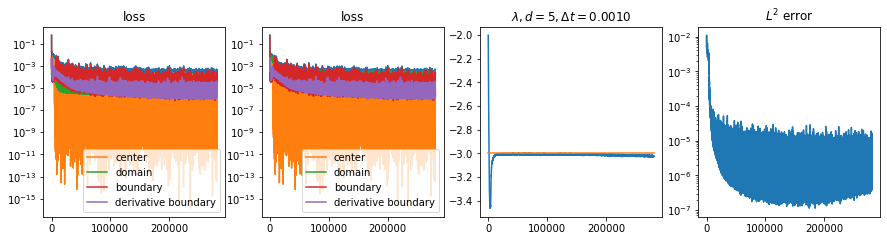

In [107]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

ax[0].plot(loss_log)
ax[0].plot(loss_log_center, label='center')
ax[0].plot(loss_log_domain, label='domain')
ax[0].plot(loss_log_boundary, label='boundary')
ax[0].plot(loss_log_derivative_boundary, label='derivative boundary')
ax[0].legend()
ax[0].set_yscale('log');
ax[0].set_title('loss')
ax[1].plot(loss_log)
ax[1].plot(np.array(loss_log_center), label='center')
ax[1].plot(alpha[0] * np.array(loss_log_domain), label='domain')
ax[1].plot(alpha[1] * np.array(loss_log_boundary), label='boundary')
ax[1].plot(alpha[1] * np.array(loss_log_derivative_boundary), label='derivative boundary')
ax[1].legend()
ax[1].set_yscale('log');
ax[1].set_title('loss')
ax[2].plot(lambda_log)
ax[2].plot([0, len(lambda_log)], [problem.lambda_, problem.lambda_]);
ax[2].set_title(r'$\lambda, d = %d, \Delta t = %.4f$' % (problem.d, delta_t));
ax[3].plot(V_L2_log)
ax[3].set_yscale('log');
ax[3].set_title(r'$L^2$ error');

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


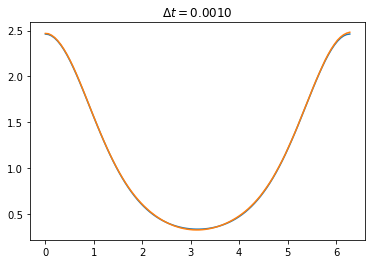

In [108]:
#X = pt.cat([pt.linspace(0, 1, 100).unsqueeze(1), pt.zeros(100, problem.d - 1)], 1).to(device)
plt.title(r'$\Delta t = %.4f$' % delta_t)
X = pt.linspace(0, 2 * np.pi, 100).unsqueeze(1).repeat(1, problem.d).to(device)
plt.plot(X[:, 0].squeeze().cpu().numpy(), problem.v_true(X.cpu()).numpy())
plt.plot(X[:, 0].squeeze().detach().cpu().numpy(), (V(X).squeeze().detach().cpu().numpy()));

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


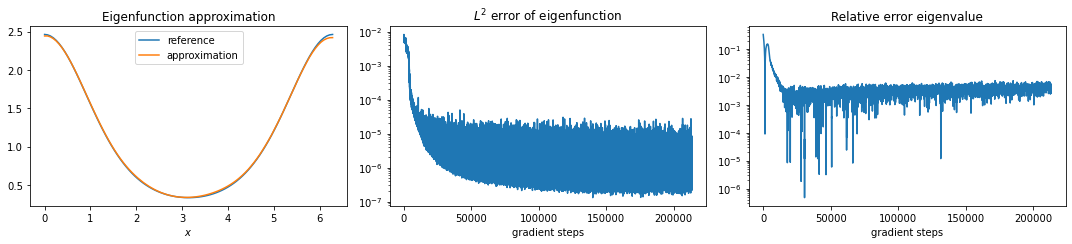

In [91]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))

ax[0].set_title(r'Eigenfunction approximation')
X = pt.linspace(0, 2 * np.pi, 100).unsqueeze(1).repeat(1, problem.d).to(device)
ax[0].plot(X[:, 0].squeeze().cpu().numpy(), problem.v_true(X.cpu()).numpy(), label='reference')
ax[0].plot(X[:, 0].squeeze().detach().cpu().numpy(), (V(X).squeeze().detach().cpu().numpy()), label='approximation');
ax[0].set_xlabel(r'$x$')
ax[0].legend()

ax[1].plot(V_L2_log)
ax[1].set_yscale('log');
ax[1].set_title(r'$L^2$ error of eigenfunction');
ax[1].set_xlabel('gradient steps')

ax[2].set_title('Relative error eigenvalue')
#ax[2].plot([(np.abs(np.mean(lambda_log[i:i + 200]) + 3)) / 3 for i in range(len(lambda_log) - 200)])
#ax[2].plot([(np.mean(np.abs(np.array(lambda_log[i:i + 200]) + 3))) / 3 for i in range(len(lambda_log) - 200)])
ax[2].plot((np.abs(np.array(lambda_log) + 3) / 3))
ax[2].set_yscale('log')
ax[2].set_xlabel('gradient steps')

#ax[2].set_title('Relative error of Eigenvalue')
#ax[2].plot([np.abs(problem.lambda_ - np.mean(lambda_log[i:i + 1000])) / (1 + problem.lambda_) for i in range(len(lambda_log) - 1000)])
#ax[2].set_yscale('log')
#ax[2].plot([0, len(lambda_log)], [problem.lambda_, problem.lambda_]);

fig.tight_layout()
#fig.savefig('img/Schroedinger-eigenvalue-d5.pdf')